The system is governed by

\begin{equation}
\nabla\cdot \vec{u}_{tot} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}_{tot}+\vec{u}\cdot\nabla\vec{u}_{tot} = -\nabla p_{tot} + \frac{Pr}{Pe}\nabla^2\vec{u}_{tot} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\vec{u}_{tot}\cdot\nabla T - w_{tot} = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\vec{u}_{tot}\cdot\nabla S - R_\rho w_{tot} = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

Decomposing nonlinear terms
$$
\vec{u}_{tot} = \bar{u}\vec{e}_x + \vec{u},
$$
$$
\vec{u}_{tot}\cdot\nabla T = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla T = \bar{u}\partial_x T + \vec{u}\cdot\nabla T,
$$
$$
\vec{u}_{tot}\cdot\nabla S = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla S = \bar{u}\partial_x S + \vec{u}\cdot\nabla S,
$$
$$
\vec{u}_{tot}\cdot\nabla \vec{u}_{tot} = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla (\bar{u}\vec{e}_x + \vec{u})\\
= \bar{u}\vec{e}_x\cdot\nabla\bar{u}\vec{e}_x + \bar{u}\vec{e}_x\cdot\nabla\vec{u} + \vec{u}\cdot\nabla\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u}\\
= 0 + \bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u},
$$

The gevorning equations become:
\begin{equation}
\nabla\cdot \vec{u}_{tot} = \nabla\cdot (\bar{u}\vec{e}_x + \vec{u}) = \nabla\cdot \vec{u} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}+\bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u} = -\nabla p + \frac{Pr}{Pe}\nabla^2\vec{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\bar{u}\partial_x T + \vec{u}\cdot\nabla T - w = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\bar{u}\partial_x S + \vec{u}\cdot\nabla S - R_\rho w = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

2024-08-20 17:57:08,439 subsystems 0/1 INFO :: Building subproblem matrices 1/96 (~1%) Elapsed: 0s, Remaining: 2s, Rate: 6.0e+01/s
2024-08-20 17:57:08,595 subsystems 0/1 INFO :: Building subproblem matrices 10/96 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 5.8e+01/s
2024-08-20 17:57:08,943 subsystems 0/1 INFO :: Building subproblem matrices 20/96 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 3.8e+01/s
2024-08-20 17:57:09,113 subsystems 0/1 INFO :: Building subproblem matrices 30/96 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 4.3e+01/s
2024-08-20 17:57:09,279 subsystems 0/1 INFO :: Building subproblem matrices 40/96 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 4.7e+01/s
2024-08-20 17:57:09,453 subsystems 0/1 INFO :: Building subproblem matrices 50/96 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 4.9e+01/s
2024-08-20 17:57:09,622 subsystems 0/1 INFO :: Building subproblem matrices 60/96 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 5.0e+01/s
2024-08-20 17:57:09,786 subsystems 0/1 INFO :: Building subproblem matr

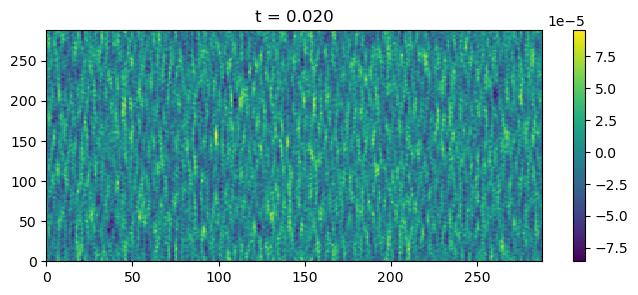

(288, 1)
(1, 192)


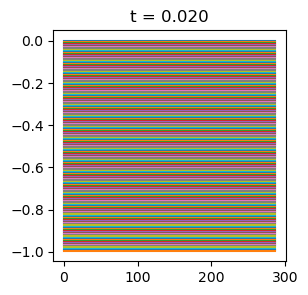

KeyboardInterrupt: 

In [9]:
# This code performs two-dimensional DNS using Dedalus3 based on governing equations in Radko's paper 
# [Thermohaline layering in dynamically and diffusively stable shear flows]
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

dealias = 3/2           # scaling factor
pi = np.pi

# reproduce the results in figure 4
# Rp, Ri, Pe, tau = 2., 1., 1e4, 0.01 # figure 3
Rp, Ri, Pe, tau = 2., 10., 1e2, 0.01 # figure 4

Pr = 10.  # Prandtl number

Lx, Lz = 64., 1.
# Nx, Nz = 1024, 384
Nx, Nz = 192, 192
# Nx, Nz = 768, 384

# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)
# define fields
p = dist.Field(name='p', bases=(xbasis,zbasis)) # pressure
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis)) # velocity
sa = dist.Field(name='sa', bases=(xbasis,zbasis)) # salinity
te = dist.Field(name='te', bases=(xbasis,zbasis)) # temperature
baru = dist.Field(bases=(zbasis))

# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define vertical velocity component
w = u @ ez

# create constant sub-field for incompressible flow condition's equation
tau_p = dist.Field(name='tau_p') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

grad_te = d3.grad(te) # First-order reduction
grad_sa = d3.grad(sa) # First-order reduction
grad_u = d3.grad(u) # First-order reduction
# First-order form: "lap(f)" becomes "div(grad_f)"
lap_u = d3.div(grad_u)
lap_te = d3.div(grad_te)
lap_sa = d3.div(grad_sa)
# First-order form: "div(A)" becomes "trace(grad_A)"

dx = lambda A: d3.Differentiate(A, coords['x']) 
dz = lambda A: d3.Differentiate(A, coords['z']) 

baru['g'] = np.sin(2*pi*z)

# Problem
problem = d3.IVP([p, tau_p, u, te, sa], namespace=locals())

# add equations
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge
problem.add_equation("dt(u) + baru*dx(u) + w*dz(baru)*ex + grad(p) - (Pr/Pe)*lap_u - (4*pi*pi*Ri/(Rp-1))*(te-sa)*ez = - u@grad(u)")
problem.add_equation("dt(te) + baru*dx(te) - (1./Pe)*lap_te - w = - u@grad(te)")
problem.add_equation("dt(sa) + baru*dx(sa) - (tau/Pe)*lap_sa - Rp*w = - u@grad(sa)")

stop_sim_time = 700 # Stopping criteria
# timestepper = d3.RK443 # 3rd-order 4-stage DIRK+ERK scheme [Ascher 1997 sec 2.8] https://doi-org.ezproxy.lib.uconn.edu/10.1016/S0168-9274(97)00056-1
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# define initial condition

p.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
u.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
te.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
sa.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise

dataset = solver.evaluator.add_file_handler('Figure4', sim_dt=1.0, max_writes=1000)
dataset.add_task(te, name='temperature')
dataset.add_task(sa, name='salinity')
dataset.add_task(p, name='pressure')
dataset.add_task(u@ex, name='velocity_u')
dataset.add_task(u@ez, name='velocity_w')
dataset.add_task(-d3.div(d3.skew(u)), name='vorticity')

# Average of the field
sa_ave = d3.Average(sa, ('x'))
te_ave = d3.Average(te, ('x'))
# print('f average:', f_ave.evaluate()['g'])

max_timestep = 0.02
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10,max_dt=max_timestep,
             safety=0.2,
             threshold=0.1,
             max_change=1.5, min_change=0.5
             )
CFL.add_velocity(u)
import math
# Main loop
print('Starting main loop')
while solver.proceed:
    timestep = CFL.compute_timestep()
    solver.step(timestep)
    if (solver.iteration-1) % 5000 == 0:
        print('Completed iteration {}, time={:.3f}, dt={:.10f}'.format(solver.iteration, solver.sim_time, timestep))
        temp_T = np.copy(te['g'])
        plt.figure(figsize=(8,3))
        te_plot = plt.pcolormesh(temp_T.transpose())
        plt.colorbar(te_plot) 
        plt.title("t = {:.3f}".format(solver.sim_time))
        plt.show()

        # temp_S = np.copy(sa['g'])
        # mean_density = (sa_ave.evaluate()['g']-te_ave.evaluate()['g'])+(1.-Rp)*z
        # print(sa_ave.evaluate()['g'].shape)
        # print(z.shape)
        # plt.figure(figsize=(3,3))
        # plt.plot(mean_density)
        # plt.title("t = {:.3f}".format(solver.sim_time))
        # plt.show()
    
    temp = np.copy(te['g'])
    if math.isnan(np.max(temp)):
        print("NaN")
        break